# Ridge Regression

In [110]:
import numpy as np
import matplotlib.pyplot as plt

## Overfitting

Let us now use the same example that we saw in the previous notebook to study overfitting. In our toy dataset, we shall use $p = 20$ (where it was $p = 8$ earlier). Now, we will also have a training and validation dataset. Both of them will have $n = 20$ data-points, sampled from the same underlying distribution.

### Dataset

In [111]:
rng = np.random.default_rng(seed = 10)
n = 20
x = np.linspace(-1, 1, 2 * n)
p = 20
X = np.array([x ** j for j in range(p + 1)])
y_true = np.sin(2 * np.pi * x)
y = y_true  + rng.normal(0, 0.2, 2 * n)
x_train, X_train, y_train = x[::2], X[:, ::2], y[::2]
x_valid, X_valid, y_valid = x[1::2], X[:, 1::2], y[1::2]

### Visualize

Let us visualize the training data and validation data in the same plot.

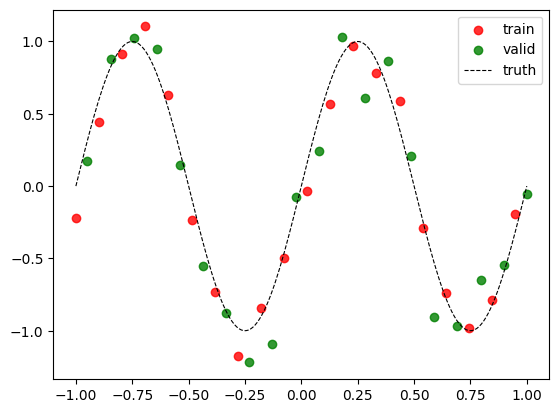

In [112]:
plt.scatter(
    x_train, y_train,
    alpha = 0.8,
    color = 'red',
    label = 'train'
    )
plt.scatter(
    x_valid, y_valid,
    alpha = 0.8,
    color = 'green',
    label = 'valid'
    )
x_vis = np.linspace(-1, 1, 200)
y_true_vis = np.sin(2 * np.pi * x_vis)
plt.plot(x_vis, y_true_vis,
         linestyle = '--',
         color = 'black',
         linewidth = 0.8,
         label = 'truth')
plt.legend();

## Normal Equations

We will now use linear regression and see what happens.

In [113]:
w_linear = np.linalg.pinv(X_train.T) @ y_train

### Visualize

Let us now look at the regression curve. We will write this as a function so that we can reuse it later.

In [114]:
def visualize(w):
    plt.scatter(
        x_train, y_train,
        alpha = 0.8,
        color = 'red',
        label = 'train'
        )
    plt.scatter(
        x_valid, y_valid,
        alpha = 0.8,
        color = 'green',
        label = 'valid'
        )
    x_vis = np.linspace(-1, 1, 200)
    y_true_vis = np.sin(2 * np.pi * x_vis)
    y_pred_vis = np.array(
        [w[i] * (x_vis ** i)
        for i in range(w.shape[0])]).sum(axis = 0)
    plt.plot(x_vis, y_pred_vis,
            color = 'red',
            label = 'predicted')
    plt.plot(x_vis, y_true_vis,
            linestyle = '--',
            color = 'black',
            linewidth = 0.8,
            label = 'truth')
    plt.legend()

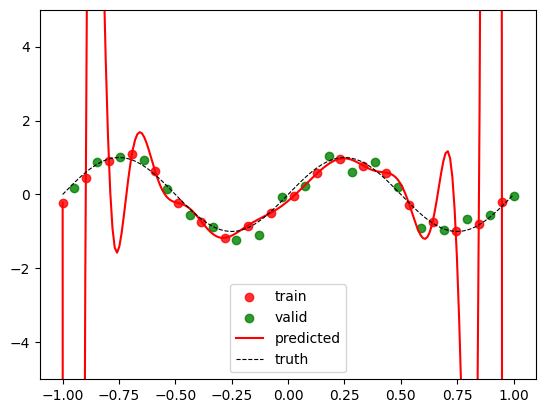

In [115]:
visualize(w_linear)
plt.ylim(-5, 5);

We see the extent of overfitting here visually. We can also study the magnitudes of the weights involved:

In [116]:
print(np.min(w_linear), np.max(w_linear))

-3074832.51598469 2297121.2998212073


We see the huge magnitudes and a wide range. The polynomial is twisting and turning to ensure that it fits the training data as well as it can, in fact, forcing itself to pass through each data-point. But in the process, it ends up fitting the noise as well.

To get a numerical estimate of the extent of overfitting, let us compare the training and test losses.

## Loss function

In [117]:
def loss(X, y, w):
    err = X.T @ w - y
    return (err ** 2).sum() / 2
train_loss = loss(X_train, y_train, w_linear)
valid_loss = loss(X_valid, y_valid, w_linear)
print(f'Train loss = {train_loss}')
print(f'Validation loss = {valid_loss}')

Train loss = 1.2308985803562101e-17
Validation loss = 6193096.573388016


We see that the training loss is zero! The regression curve passes through every data-point!

# Ridge regression

## Regualarized Loss function

Recall that ridge regression tries to minimize the regularized loss function given by:

$$
\begin{equation*}
L(\mathbf{X} ,\mathbf{y} ,\mathbf{w}) =\frac{1}{2}\sum\limits _{i=1}^{n}\left(\mathbf{w}^{T}\mathbf{x}_{i} -y_{i}\right)^{2} +\frac{\lambda }{2} ||\mathbf{w} ||^{2}
\end{equation*}
$$

where $\lambda$ is the regularization rate.

In [118]:
def loss(X, y, w, lamb):
    err = X.T @ w - y
    return (
        (err ** 2).sum() / 2
        + (lamb / 2) * (w ** 2).sum()
    )

## Closed Form Solution

Since ridge regression makes use of the $L_2$ loss, we still have a closed form expression for the optimal weight vector:

$$
\begin{equation*}
\mathbf{w}^{*} =\left(\mathbf{XX}^{T} +\lambda \mathbf{I}\right)^{-1}\mathbf{Xy}
\end{equation*}
$$

Since $\mathbf{XX}^T$ is positive-semidefinite and $\lambda > 0$, we see that the inverse of the matrix mentioned above always exists.

In [119]:
def get_w_ridge(X, y, lamb = 0.1):
    d, n = X.shape
    return (
        np.linalg.inv(X @ X.T + lamb * np.eye(d))
        @ X @ y
    )
w_ridge = get_w_ridge(
    X_train,
    y_train,
    lamb = 0.01
)

## Visualize and Compare

Let us now visualize the regression curve and also study the training and validation losses.

Train loss = 1.504951077609829
Validation loss = 2.459889499040857


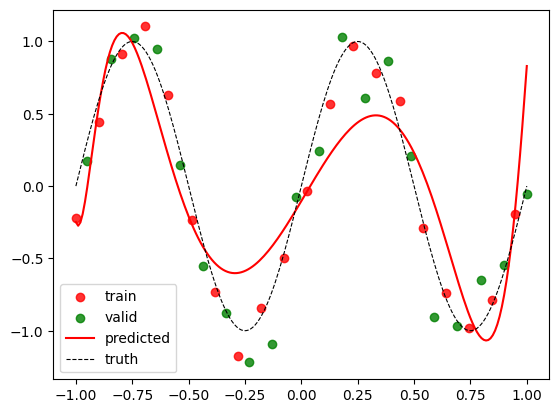

In [120]:
lamb = 0.01
visualize(w_ridge)
train_loss = loss(X_train, y_train, w_ridge, lamb)
valid_loss = loss(X_valid, y_valid, w_ridge, lamb)
print(f'Train loss = {train_loss}')
print(f'Validation loss = {valid_loss}')

This is a much better model. Note that we are now inching closer to how ML is done in practice. Let us now tune the hyperparameter $\lambda$ on the validation set. For this, we can plot the training and validation loss against $\cfrac{1}{\lambda}$.

(0.0, 10.0)

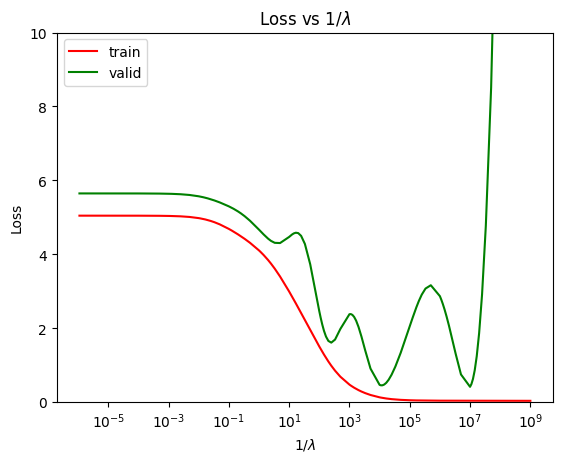

In [121]:
train_losses = [ ]
valid_losses = [ ]
lambs = np.concatenate([
    [i * (10 ** exp) for i in range(1, 10)]
    for exp in range(-9, 6)]
    )
for lamb in lambs:
    w_ridge = get_w_ridge(
        X_train,
        y_train,
        lamb = lamb
    )
    train_losses.append(loss(
        X_train,
        y_train,
        w_ridge,
        lamb)
    )
    valid_losses.append(loss(
        X_valid,
        y_valid,
        w_ridge,
        lamb)
    )
plt.plot(
    1 / lambs,
    train_losses,
    color = 'red',
    label = 'train'
)
plt.xscale('log')
plt.plot(
    1 / lambs,
    valid_losses,
    color = 'green',
    label = 'valid'
)
plt.xscale('log')
plt.legend()
plt.title(r'Loss vs $1 / \lambda$')
plt.xlabel(r'$1 / \lambda$')
plt.ylabel('Loss')
plt.ylim(0, 10)

Though this is not a classic curve between the loss function and the model complexity, it at least captures the rough behaviour of the model as $\lambda$ is varied. In the case of ridge regression, the model complexity is represented by $1 / \lambda$.

In [122]:
best_lamb = lambs[np.argmin(valid_losses)]
print(f'Best validation loss = {np.min(valid_losses)}')
print(f'Best lambda = {best_lamb}')

Best validation loss = 0.4139661801071577
Best lambda = 1e-07


Thus, the best value of $\lambda$ turns out to be $10^{-7}$.

Train loss = 0.03724601299739053
Validation loss = 0.4139661801071577


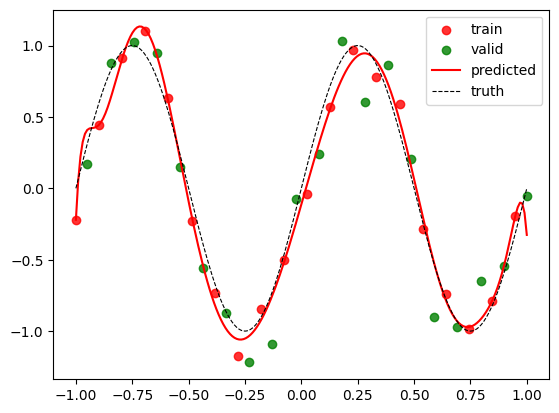

In [123]:
w_ridge = get_w_ridge(
    X_train,
    y_train,
    lamb = best_lamb
)
visualize(w_ridge)
train_loss = loss(X_train, y_train, w_ridge, best_lamb)
valid_loss = loss(X_valid, y_valid, w_ridge, best_lamb)
print(f'Train loss = {train_loss}')
print(f'Validation loss = {valid_loss}')